In [25]:
import pandas as pd
import numpy as np
from mlops_class import CustomTransformer, MLUtils
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import shap
import random

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

## Creating a Pipeline
 
We can create a ModelPipeline that preprocess the data first, and then make prediction, and maybe even offer model explanations. 

In [26]:
class ModelPipeline(BaseEstimator):

    def __init__(self, custom_transformer=None, model=None):
        self.custom_transformer = custom_transformer
        self.model = model
    
    def fit(self, X, y=None):
        X_train_transformed = self.custom_transformer.fit_transform(X, y)
        self.model.fit(X_train_transformed, y)
    
    def predict_proba(self,X):
        X_new_transformed = self.custom_transformer.transform(X)
        return self.model.predict_proba(X_new_transformed)
        
    def explain_model(self,X):
        X_transformed = self.custom_transformer.transform(X)
        explainer = shap.Explainer(self.model)
        shap_values = explainer(X_transformed)  
        try:
            shap_values.values.shape[2] 
            both_class = True
        except:
            both_class = False
        if both_class:
            shap.summary_plot(shap_values[:,:,1])
        elif both_class == False:
            shap.summary_plot(shap_values)

In [27]:
n_feature = 5
n_inform = 2
n_redundant = 1
n_bin = 0
n_samples = 500
X, y = make_classification(n_samples = n_samples, n_features = n_feature, 
                            n_informative = n_inform, n_redundant=n_redundant)

bin_features = []
cat_features = []
num_features = [f'num_{i+1}' for i in range(n_feature)]

X = pd.DataFrame(X, columns = num_features + bin_features + cat_features)
group = [random.choice([0, 1]) for _ in range(n_samples)]


In [41]:
model_pipeline = ModelPipeline(
    custom_transformer=CustomTransformer(
                        bin_features=bin_features,
                        num_features=num_features,
                        cat_features=cat_features,
                    ),
    # any modelling algorithm with sklearn API should work:
    model = xgb.XGBClassifier()
    # model = RandomForestClassifier()
    # model = lgb.LGBMClassifier(verbose=-1)
)

In [42]:
X_train, X_test, y_train, y_test = MLUtils.group_train_test_split(X,y,group,random_state=55)
model_pipeline.fit(X_train,y_train)
y_prob = model_pipeline.predict_proba(X_test)
roc_auc_score(y_test, y_prob[:,1])

0.9882062146892656

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


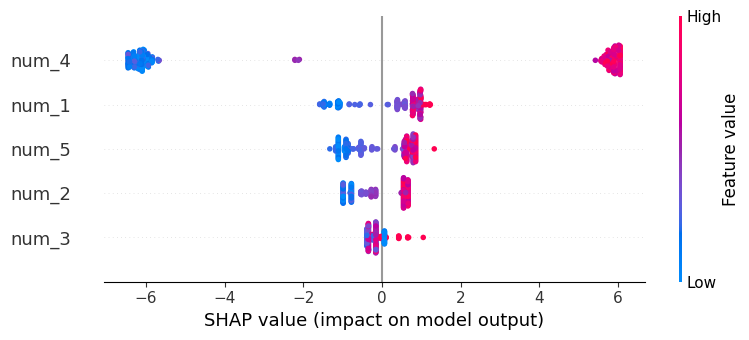

In [43]:
model_pipeline.explain_model(X_test)